# Percolation

The goal of this notebook is to implement the spread of the Covid19 pandemic using percolation.

In [3]:
import collections
import random
import time
from typing import Union

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
# import a helper function from the utils module
from utils import get_neighbors

# use the searborn style
plt.style.use("seaborn")
# make interactive plots
plt.ion()

# %matplotlib qt
%matplotlib inline

In a first step, the problem is defined:

- define the number of grid points **nx** and **ny**
- define the distance between the node, herein, social distancing can be modeled
- define the x and y coordinates and create a meshgrid
- define the active nodes as a set
    - this is done as a set because each element in a set is unique
- randomly choose one single patient zero from the nodes, as the spread starts with one single person

In [4]:
# define the number of points in x and y direction
nx, ny = 15, 15
# define the offset
offset = 1
# define the distance between the nodes
distance = 1
# define the x and y coordinates
x_coord = np.arange(start=offset, stop=nx + offset, step=distance, dtype=float)
y_coord = np.arange(start=offset, stop=ny + offset, step=distance, dtype=float)
# define the x and y limits
xlim, ylim =  (x_coord[0], x_coord[-1]), (y_coord[0], y_coord[-1])
# create a mesh
X, Y = np.meshgrid(x_coord, y_coord)
# create an array containing the coordinates of each point and the corresponding indices as array
coords = np.array(list(zip(X.flatten(), Y.flatten())), dtype=float)
idcs = np.arange(0, coords.shape[0])
# define the search tree as set from which each element which is visited will be removed
tree = {(x, y) for x, y in coords}
# select random coordinates which represent the infected persons
rng = np.random.default_rng(456)
num_infected = 1
idx = rng.choice(idcs, size=num_infected)
# get a random coordinate which represents the patient zero
pat_zero = tuple(coords[idx, :].reshape(-1,))

Next, the probability of infection given the distance and the eposure time has to be determined, i.e.
$$ P(\text{infection}|\text{distance, exposure time}) $$
This is rather comlicated.

In [5]:
# define the probability of infection
# TODO: Add function for proability based on distance and exposure time
def prob_infection(distance, exposure_time):
    pass
p_infect = 0.5

In [6]:
# define the color black with a hex string
black = "#000000"
red = "#ff0000"
orange = "#e69500"
blue = "#0000ff"
green = "#006200"
# define the figure
nrows, ncols = 1, 1
fig1 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows, ncols, figure=fig1)
ax1 = fig1.add_subplot(gs[0, 0])
# plot the grid
ax1.plot(X, Y, color=black)
ax1.plot(Y, X, color=black)
ax1.plot(*pat_zero, marker='o', ms=10, color=blue, ls="", label="pat. zero")
ax1.legend()
# prevent the plot from showing as this is shown below
plt.close()

The pseudo code algorithm of the percolation can be seen below:

    INIT frontier with patient zero
    INIT tree with patients
    INIT infected as empte queue

    START Percolation takes frontier, tree, and infected as input

        IF frontier is not empty
            node <- frontier.pop()
            infected.append()
        ELSE
            RETURN
        ENDIF
        tree.remove(node)
        INIT neighbors <- get_neighbors
        INIT infected neighbors <- SUBSET neighbors
        FOR x, y in infected neighbors
            IF x, y not in tree OR x, y in frontier
                CONTINUE
            ENDIF
            frontier.append(x, y)
        ENDFOR
        Percolation(frontier, tree, infected)

Notice that a deque is used instead of a list, which is because a deque has appending and pop costs of $\mathcal{O}(1)$.
In contrast, lists have appending costs of $\mathcal{O}(n)$.
See [the official python documentation](https://docs.python.org/3/library/collections.html#collections.deque).

In [7]:
def percolation(frontier: collections.deque, tree: set, infected: collections.deque, route: collections.defaultdict, p_infect: float) -> None:
    # print(f"Frontier: {frontier}")
    if frontier:
        node = frontier.pop()
        infected.append(node)
        # print(f"Infected: {infected}")
    else:
        # print(f"Should return: {infected}")
        return
    tree.remove(node)
    neighbors = get_neighbors(node, distance, x_limit=xlim, y_limit=ylim)
    mask = rng.random(size=neighbors.shape[0]) < p_infect
    for x, y in neighbors[mask]:
        if (x, y) not in tree or (x, y) in frontier:
            continue
        frontier.append((x, y))
        route[node].append((x, y))
    percolation(frontier, tree, infected, route, p_infect)

In [8]:
# define the frontier
frontier = collections.deque([pat_zero])
# define the infected people
infected = collections.deque()
route = collections.defaultdict(list)
percolation(frontier, tree, infected, route, p_infect)

In [9]:
def plot_percolation(fig, ax, infected, tree, route):
    ax.plot(*np.array(infected)[1:, ...].transpose(), color=green, marker="o", ms=10, ls="", label="infected")
    ax.plot(*np.array(list(tree)).transpose(), color=orange, marker="o", ms=10, ls="", label="healthy")
    for parent, child in route.items():
        for x_c, y_c in child:
            ax.arrow(parent[0], parent[1], x_c - parent[0], y_c - parent[1], width=1 / 125 * min(nx, ny), length_includes_head=True, head_width=1 / 55 * min(nx, ny), color=red)
    ax.legend(bbox_to_anchor=(1, 1))
    return fig

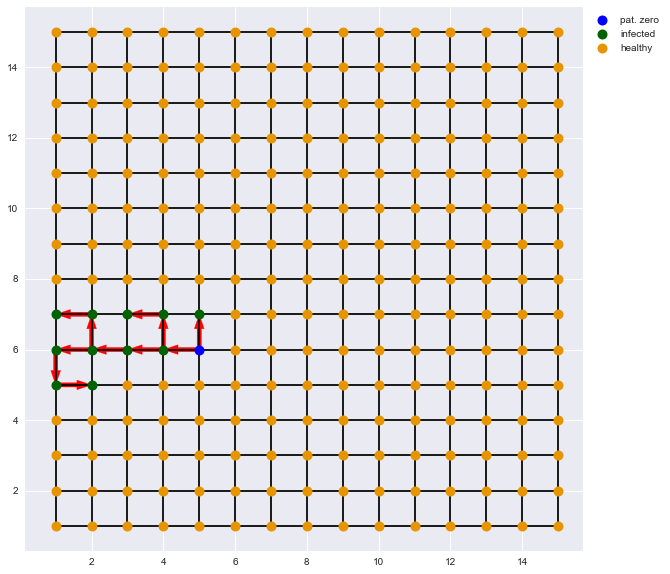

In [10]:
plot_percolation(fig1, ax1, infected, tree, route)

Display the results for different probabilites of infection.

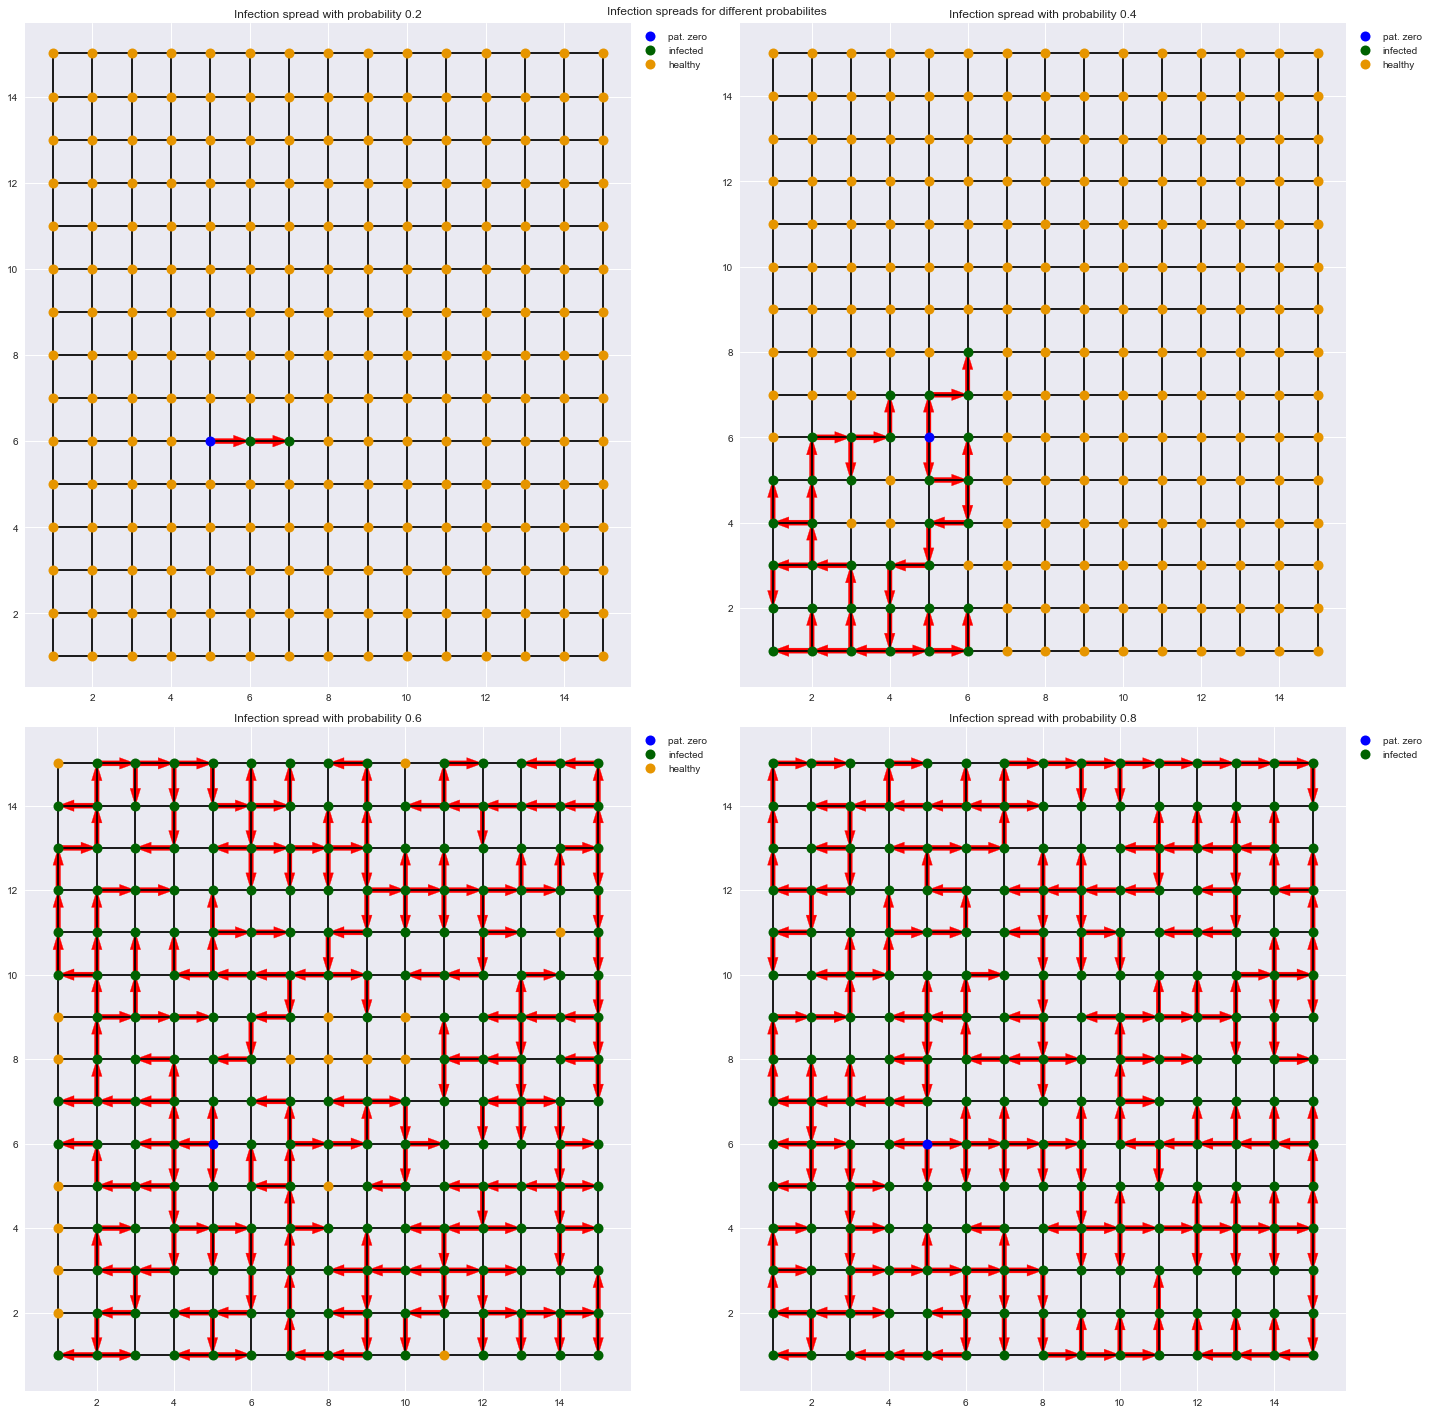

In [11]:
# define the probabilites
p_infect = [0.2, 0.4, 0.6, 0.8]

# define the figure
nrows, ncols = 2, 2
fig2 = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(nrows, ncols, figure=fig2)
axes = [
    fig2.add_subplot(gs[0, 0]),
    fig2.add_subplot(gs[0, 1]),
    fig2.add_subplot(gs[1, 0]),
    fig2.add_subplot(gs[1, 1]),
]

for counter, p in enumerate(p_infect):
    # herein, the tree has to be filled in each iteration
    tree = {(x, y) for x, y in coords}
    # define the frontier
    frontier = collections.deque([pat_zero])
    # define the infected people
    infected = collections.deque()
    route = collections.defaultdict(list)
    percolation(frontier, tree, infected, route, p)
    axes[counter].plot(X, Y, color=black)
    axes[counter].plot(Y, X, color=black)
    axes[counter].plot(*pat_zero, marker='o', ms=10, color=blue, ls="", label="pat. zero")
    plot_percolation(fig2, axes[counter], infected, tree, route)
    
    axes[counter].set_title(f"Infection spread with probability {p}")
fig2.suptitle("Infection spreads for different probabilites")
fig2.tight_layout()